# Purpose
<br/><i>
The overtopping discharge estimations are computed from an empirical method explain in the Eurotop manual (http://www.overtopping-manual.com/).  These equations have been setup from the CLASH database (see below). However, the accuracy of theses equations is problematic when the inputs parameters are closed from the validation domain (who happens very often). 
<br/><br/>
The access to the CLASH database can allow the ML and DP utilizations for increase the accuracy of the overtopping discharges.<br/><br/>
The first step, here, is to define the possibilities given by the ML algorithms regressor. A simple Decision tree regressor and more complex model Gradient Boost regressor have been setup and compared. </i>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge

# Pre-processing data
<br/> 
<i>
The data is the database created within the framework of
the European project CLASH. This database includes tests
collected from several laboratories. Results from about 10,000 overtopping tests are included in
the database. Each of these tests is described by a number of
parameters that represent hydraulic information (i.e. incident
wave characteristics and measured overtopping discharges) as
well as structural information (i.e. parameters characterising the test sections).<br/><br/>    
Moreover, the database includes some general
information regarding the reliability of the test and the
complexity of the structure. The reliability of each test was
estimated and defined in terms of a Reliability Factor (RF). In
the present database the values of the RF ranged from RF=1 for
a ‘very reliable’ test to RF= 4 for a ‘non-reliable’ test. RF=1
was given to tests for which all required information was
available in the corresponding reports and no variable
estimation was needed, while RF=4 was given to tests for
which the estimation of some parameters was not acceptable
and for which the measurements included many uncertainties.<br/><br/> 
In a similar way, the complexity of each test was estimated and
defined in terms of a Complexity Factor (CF). CF=1 was given
to tests with a ‘very simple’ structure in which the parameters
describe the cross-section exactly, while CF=4 was given to
tests with a ‘very complex’ structure in which the cross-section
cannot accurately be described by the chosen parameters.</i> 
    

    
![Features_inputs](Features_inputs.JPG "Features_inputs")    

## import csv file and clean the data

In [ ]:
Path = 'E:\\PROJETS\\PROJET_DATA_SCIENCE\\ML_OVERTOPPING\\'
File = 'Database_20050101v2.xls'
df_Data = pd.read_excel(Path+File)

<i>For the cleaning data process : </br></i>

- <i>deleted the non interesting data</i>
- <i>deleted the overtopping discharges equal to 0 </i>
- <i>deleted the NaN </i>
- <i>deleted the line with RF and CF = 4 corresponding to the estimations no acceptables</i>

In [15]:
clean_data(df_Data)

In [70]:
df_Data.dtypes

Hm0 deep        object
Tp deep         object
Tm deep         object
Tm-1,0 deep     object
h deep          object
m              float64
b               object
h               object
Hm0 toe         object
Tp toe          object
Tm toe          object
Tm-1,0 toe      object
ht              object
Bt              object
gf             float64
cotad          float64
cotau          float64
cotaexcl       float64
cotaincl       float64
Rc              object
B               object
hb              object
tanaB          float64
Bh              object
Ac              object
Gc              object
q               object
dtype: object

In [16]:
df_Data.astype('float').head()

,Hm0 deep,Tp deep,Tm deep,"Tm-1,0 deep",h deep,m,b,h,Hm0 toe,Tp toe,...,cotaexcl,cotaincl,Rc,B,hb,tanaB,Bh,Ac,Gc,q
5,0.138125,2.165217,1.804348,1.968379,0.23625,42.857143,0.0,0.085000,0.063000,2.165217,...,0.000000,0.000000,0.025000,0.0,0.0,0.0,0.0,0.008750,0.431875,0.002063
11,0.138125,2.165217,1.804348,1.968379,0.23625,42.857143,0.0,0.085000,0.063000,2.165217,...,0.000000,0.000000,0.100000,0.0,0.0,0.0,0.0,0.031250,0.431875,0.000188
17,0.138125,2.165217,1.804348,1.968379,0.23625,42.857143,0.0,0.085000,0.063000,2.165217,...,0.000000,0.000000,0.025000,0.0,0.0,0.0,0.0,0.083750,0.431875,0.000406
26,0.152308,1.665648,1.388040,1.514225,0.80000,66.000000,0.0,0.326154,0.152308,1.665648,...,1.333333,1.333333,0.273846,0.0,0.0,0.0,0.0,0.215385,0.076923,0.000203
27,0.187077,2.104939,1.754116,1.913581,0.80000,66.000000,0.0,0.326154,0.187077,2.104939,...,1.333333,1.333333,0.273846,0.0,0.0,0.0,0.0,0.215385,0.076923,0.000718


## Split the data in train and test set

In [17]:
df_train_set, df_test_set = train_test_split(df_Data, test_size=0.2,
                                             random_state=42)

df_features = df_train_set.drop(['q'], axis=1)
df_target = df_train_set['q']
scaler = StandardScaler()
df_features_scaled = pd.DataFrame(scaler.fit_transform(df_features))
df_features_scaled.columns = df_features.columns

df_features_test = df_test_set.drop(['q'], axis=1)
df_target_test = df_test_set['q']
df_features_test_scaled = pd.DataFrame(scaler.fit_transform(df_features_test))
df_features_test_scaled.columns = df_features_test.columns

# Regression models

## Decision tree regressor model 

### train the model
*Using the gridsearchCv for find the best hyperparameters.<br/> 
the hyperparameters tested:*<br/>
- *Max depth*
- *Min samples leaf*
- *max features* 

In [18]:
params_Grid = {'max_depth': [14, 17, 18, 19, 20],
               'min_samples_leaf': [1, 2, 3, 4],
               'max_features': [1, 2, 5, 6]
               }
scoring = ['neg_mean_absolute_error',
           'neg_mean_squared_error',
           'neg_median_absolute_error',
           'r2']

DecisionTreeR(params_Grid, 5, scoring, df_features_scaled, df_target)



######### Tuning hyper-parameters for neg_mean_absolute_error

Best parameters set found on development set:
{'max_depth': 20, 'max_features': 6, 'min_samples_leaf': 2}  -----> SCORE: -0.000367


######### Tuning hyper-parameters for neg_mean_squared_error

Best parameters set found on development set:
{'max_depth': 17, 'max_features': 2, 'min_samples_leaf': 2}  -----> SCORE RMSE: 0.001918


######### Tuning hyper-parameters for neg_median_absolute_error

Best parameters set found on development set:
{'max_depth': 20, 'max_features': 5, 'min_samples_leaf': 4}  -----> SCORE: -0.000080


######### Tuning hyper-parameters for r2

Best parameters set found on development set:
{'max_depth': 20, 'max_features': 6, 'min_samples_leaf': 2}  -----> SCORE: 0.879907


### model on the test set

In [84]:
DTR = DecisionTreeRegressor(random_state=42,
                            max_depth=17,
                            min_samples_leaf=2,
                            max_features=2,
                            )
DTR.fit(df_features_scaled, df_target)

target_prediction = DTR.predict(df_features_test_scaled)

_score(df_target_test, target_prediction)



############## SCORE DATASET TEST ########

R2 TEST
0.8296923158345433

RMSE TEST
0.0035689978051939753


In [ ]:
plot_learning_curve(DTR,df_features_scaled, df_target, train_sizes)

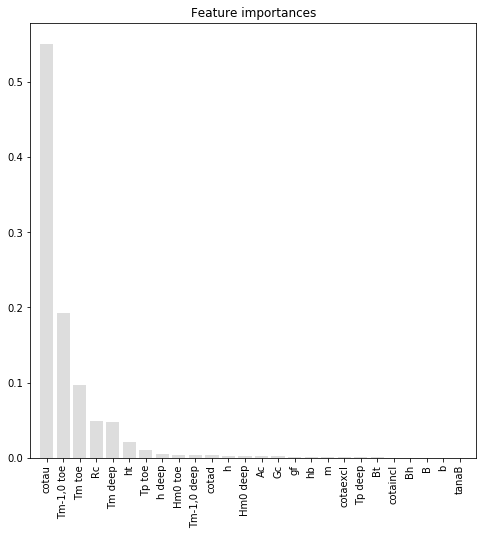

In [86]:
features_importances(DTR,df_features_scaled)

## Gradient Boost Regressor model  

### train the model
*Using the gridsearchCv for find the best hyperparameters.<br/> 
the hyperparameters tested:*<br/>
- *Max depth*
- *Min samples leaf*
- *max features*
- *learning_rate*

In [58]:
scoring = [  # 'neg_mean_absolute_error',
    'neg_mean_squared_error',
    # 'neg_median_absolute_error',
    'r2']

params_Grid = {'learning_rate': [0.1, 0.4, 0.6, 0.8, 1],
               'max_depth': [13, 14, 15],
               'min_samples_leaf': [7, 8, 9],
               'max_features': [10, 11, 12, 13, 14],
               'n_estimators': [150]
               }

GradientBoostR(params_Grid, 5, scoring, df_features_scaled, df_target)


######### Tuning hyper-parameters for neg_mean_squared_error


Best parameters set found on development set:
{'learning_rate': 0.4, 'max_depth': 14, 'max_features': 12, 'min_samples_leaf': 8, 'n_estimators': 150}  -----> SCORE RMSE: 0.001686

######### Tuning hyper-parameters for r2


Best parameters set found on development set:
{'learning_rate': 0.6, 'max_depth': 14, 'max_features': 11, 'min_samples_leaf': 8, 'n_estimators': 150}  -----> SCORE: 0.888929


### model on the test set

In [19]:
GBR = GradientBoostingRegressor(learning_rate=0.6,
                                max_depth=14,
                                min_samples_leaf=8,
                                max_features=12,
                                n_estimators=150,
                                random_state=42)
GBR.fit(df_features_scaled, df_target)

target_prediction = GBR.predict(df_features_test_scaled)

_score(df_target_test, target_prediction)



############## SCORE DATASET TEST ########

R2 TEST
0.9146491043883737

RMSE TEST
0.002526580852041071


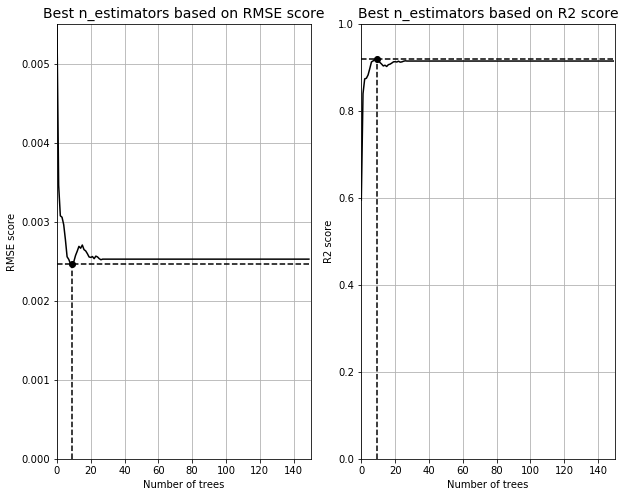

In [20]:
Best_n_estimator(GBR, df_features_scaled, df_target, df_features_test_scaled, df_target_test,150)  

In [21]:
GBR = GradientBoostingRegressor(learning_rate=0.6,
                                max_depth=14,
                                min_samples_leaf=8,
                                max_features=12,
                                n_estimators=10,
                                random_state=42)
GBR.fit(df_features_scaled, df_target)

target_prediction = GBR.predict(df_features_test_scaled)

_score(df_target_test, target_prediction)



############## SCORE DATASET TEST ########

R2 TEST
0.9180196274089474

RMSE TEST
0.0024761907848990963


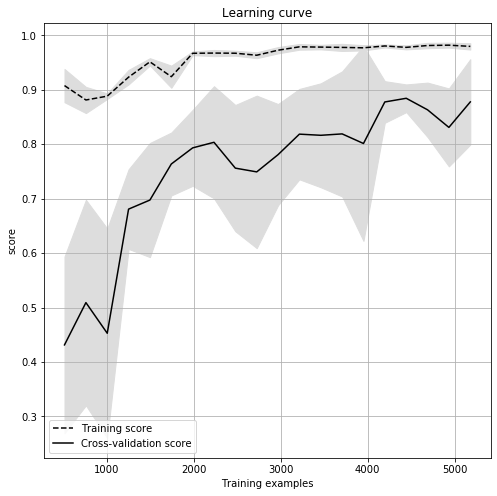

In [22]:
train_sizes = np.linspace(0.1, 1, 20)
plot_learning_curve(GBR, df_features_scaled, df_target, train_sizes)

- <i>The cross validation curve trends to converge to the Training curve but not completely. Potentially this model would benefit from more training data.</i>
- <i>The low instabilities of the Training curve shape show low Biais. the instabilities of the Cross validation curve, show a variance problem.</i>  
- <i>Low biais and High variance can show an overfitting problem.</i>


### Target prediction vs target test

[0, 0.175313016894277, 0, 0.1393319794169737]

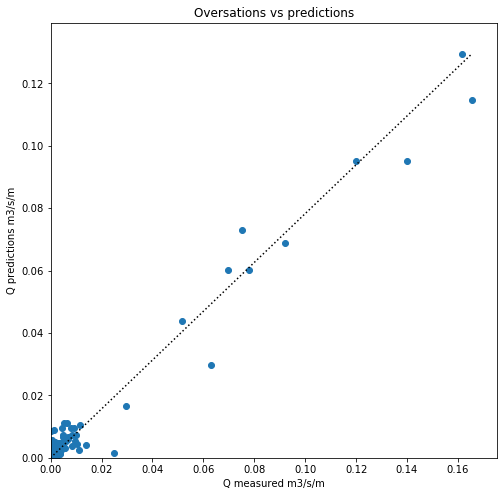

In [48]:
plt.figure(figsize=(8, 8))
plt.title('Oversations vs predictions')
plt.xlabel("Q measured m3/s/m")
plt.ylabel("Q predictions m3/s/m")
plt.scatter(df_target_test, target_prediction)
plt.plot(np.linspace(0, df_target_test.max()),
         np.linspace(0, target_prediction.max()), ':k')
plt.axis([0, df_target_test.max()+0.01, 0, target_prediction.max()+0.01])

[0, 0.02, 0, 0.02]

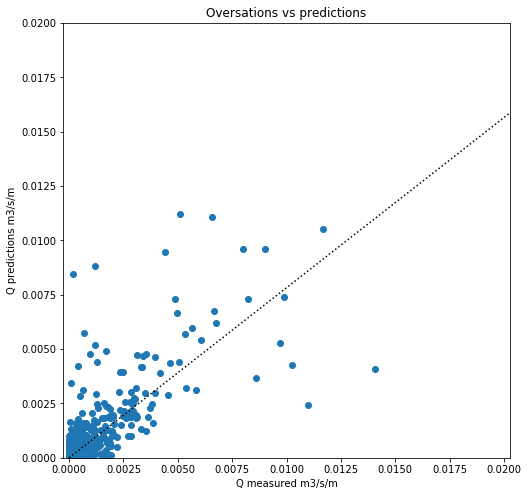

In [49]:
plt.figure(figsize=(8, 8))
plt.axis("equal")
plt.title('Oversations vs predictions')
plt.xlabel("Q measured m3/s/m")
plt.ylabel("Q predictions m3/s/m")
plt.scatter(df_target_test, target_prediction)
plt.plot(np.linspace(0, df_target_test.max()),
                    np.linspace(0, target_prediction.max()), ':k')
plt.axis([0, 0.02, 0, 0.02])

## Next steps
<br/><i>
The Gradient Boost Regressor model developed here shows correct results but not enough for make a good prediction of the overtopping discharge. The learning curve shows probably an overfitting problem with low biais but higher variance.<br/> <br/> 
26 variables are taking into account for make the predictions. the feature importances diagram shows an important difference of weight in the Tree regressor process. For reduce the overfitting problem, a dimension reduction can be tested (PCA method). <br/><br/>
The prediction model is built for all the data set, excepted for the CF and RF equal to 4 (complex dike profiles). One solution should be to classify the profiles according to the input parameters and for each classification build a regressor model. </i>


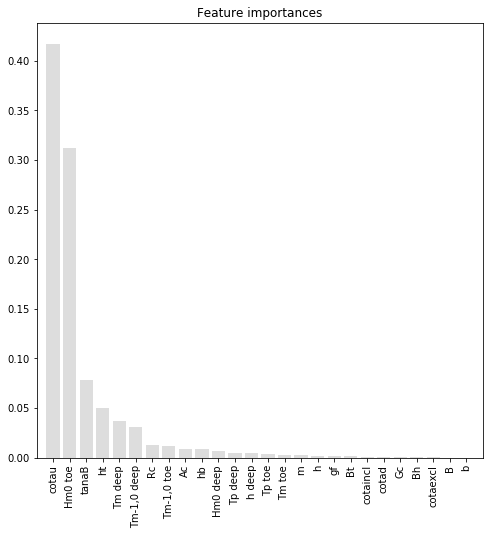

In [23]:
features_importances(GBR,df_features_scaled)

# List of functions 

### clean_data function

In [7]:
def clean_data(data):
    """
    clean_data clean the data from the csv file.
    the function delete the strings rows and delete the NaN values.
    """
    del data['Reference'], data['Remark'], data['Name'], data['Pow']
    data.drop([0], inplace=True)
    data.dropna(inplace=True)
    data.drop(data.index[data['RF'] == 4], inplace=True)
    data.drop(data.index[data['CF'] == 4], inplace=True)
    data.drop(data.index[data['q'] == 0], inplace=True)
    del data['RF'], data['CF']

### DecisionTreeR function

In [8]:
def DecisionTreeR(params, cv, scoring, features, target):
    reg_tree = DecisionTreeRegressor(random_state=42)
    for x in scoring:
        grid_search = GridSearchCV(reg_tree,
                                   params_Grid,
                                   cv=cv,
                                   scoring=x,
                                   n_jobs=-1)
        grid_search.fit(features, target)
        print()
        print()
        print("######### Tuning hyper-parameters for %s" % x)
        print()
        print("Best parameters set found on development set:")
        if x == 'neg_mean_squared_error':
            print(grid_search.best_params_, ' -----> SCORE RMSE: %f' %
                  np.sqrt(-grid_search.best_score_))
        else:
            print(grid_search.best_params_, ' -----> SCORE: %f' %
                  grid_search.best_score_)

### GradientBoostR function

In [9]:
def GradientBoostR(params, cv, scoring, features, target):

    GBR = GradientBoostingRegressor(random_state=42)

    for x in scoring:
        grid_search = GridSearchCV(estimator=GBR,
                                   cv=cv,
                                   param_grid=params,
                                   n_jobs=-1,
                                   scoring=x
                                   )
        grid_search.fit(features, target)
        print()
        print("######### Tuning hyper-parameters for %s" % x)
        print()
        print()
        print("Best parameters set found on development set:")
        if x == 'neg_mean_squared_error':
            print(grid_search.best_params_, ' -----> SCORE RMSE: %f' %
                  np.sqrt(-grid_search.best_score_))
        else:
            print(grid_search.best_params_, ' -----> SCORE: %f' %
                  grid_search.best_score_)

### Best_n_estimator function

In [10]:
def Best_n_estimator(GBR, features, target, features_test, target_test, n_estimators):
    GBR.fit(features, target)
    errors_RMSE = [np.sqrt(mean_squared_error(target_test, target_predictions))
                   for target_predictions in GBR.staged_predict(features_test)]
    errors_R2 = [r2_score(target_test, target_predictions)
                 for target_predictions in GBR.staged_predict(features_test)]
    bst_n_estimators_RMSE = np.argmin(errors_RMSE) + 1
    bst_n_estimators_R2 = np.argmax(errors_R2)+1
    min_error_RMSE = np.min(errors_RMSE)
    min_error_R2 = np.max(errors_R2)

    plt.figure(figsize=(10, 8))

    plt.subplot(1, 2, 1)
    plt.plot(errors_RMSE, "k")
    plt.plot([bst_n_estimators_RMSE, bst_n_estimators_RMSE],
             [0, min_error_RMSE], "k--")
    plt.plot([0, n_estimators], [min_error_RMSE, min_error_RMSE], "k--")
    plt.plot(bst_n_estimators_RMSE, min_error_RMSE, "ko")
    plt.axis([0, n_estimators, 0, np.max(errors_RMSE)])
    plt.xlabel("Number of trees"), plt.ylabel("RMSE score")
    plt.title("Best n_estimators based on RMSE score", fontsize=14)
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(errors_R2, "k")
    plt.plot([bst_n_estimators_R2, bst_n_estimators_R2],
             [0, min_error_R2], "k--")
    plt.plot([0, n_estimators], [min_error_R2, min_error_R2], "k--")
    plt.plot(bst_n_estimators_R2, min_error_R2, "ko")
    plt.axis([0, n_estimators, 0, 1])
    plt.xlabel("Number of trees"), plt.ylabel("R2 score")
    plt.title("Best n_estimators based on R2 score", fontsize=14)
    plt.grid()

### score function

In [11]:
def _score(Y_test, Y_predictions):
    print()
    print()
    print("############## SCORE DATASET TEST ########")
    print()
    print("R2 TEST")
    print(r2_score(Y_test, Y_predictions))
    print()
    print("RMSE TEST")
    print(np.sqrt(mean_squared_error(Y_test, Y_predictions)))

### learning curve function

In [12]:
def plot_learning_curve(estimator, features, target, train_sizes):

    plt.figure(figsize=(8, 8))
    plt.title('Learning curve')
    plt.xlabel("Training examples")
    plt.ylabel("score")

    estimator.fit(features, target)
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator, features, target, cv=5, n_jobs=-1, train_sizes=train_sizes, scoring='r2')

    train_scores_mean = train_scores.mean(axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = validation_scores.mean(axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, color="#dddddd")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, color="#dddddd")
    plt.plot(train_sizes, train_scores_mean, '--',
             color="k", label="Training score")
    plt.plot(train_sizes, validation_scores_mean,
             color="k", label="Cross-validation score")
    plt.legend(loc="best")

### Features importances function

In [13]:
def features_importances(estimator, features):
    importances = estimator.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(8, 8))
    plt.title("Feature importances")
    plt.bar(range(len(importances)),
            importances[indices], color="#dddddd", align="center")
    plt.xticks(range(len(importances)),
               features.columns[indices], fontsize=10, rotation=90)
    plt.xlim([-1, len(importances)])
    plt.show()

### PCA_plot function 

In [51]:
def PCA_plot(features):
    pca = PCA()
    pca.fit(features)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    d = np.argmax(cumsum >= 0.95)

    plt.figure(figsize=(8, 8))
    plt.plot(cumsum, linewidth=2, color='k')
    plt.axis([0, features.shape[1], 0, 1])
    plt.xlabel("Dimensions")
    plt.ylabel("Explained Variance")
    plt.plot([d, d], [0, 0.95], ':', color="k")
    plt.plot([0, d], [0.95, 0.95], ':', color="k")
    plt.plot(d, 0.95, "ko")
    plt.grid(True)
    print()
    print('### Dimensions keeping 95 % of the variance:')
    print(d)
    print()

# Miscellaneous
## Reduction dimension PCA and GradientBoostingRegressor


### Dimensions keeping 95 % of the variance:
9



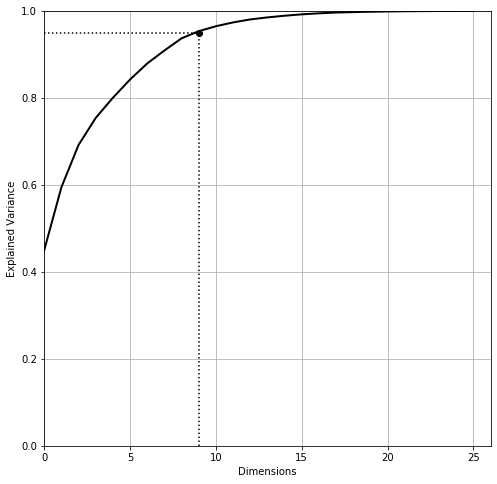

In [52]:
PCA_plot(df_features_scaled)

In [53]:
pca = PCA(n_components=10)
pca.fit(df_features_scaled)
df_features_scaled_PCA = pca.fit_transform(df_features_scaled)
df_features_test_scaled_PCA = pca.fit_transform(df_features_test_scaled)

In [54]:
GBR = GradientBoostingRegressor(learning_rate=0.4,
                                 max_depth=14,
                                 min_samples_leaf=6,
                                 max_features=1,
                                 n_estimators=150,
                                 random_state=42)
GBR.fit(df_features_scaled_PCA,df_target)

target_prediction = GBR.predict(df_features_test_scaled_PCA)

_score(df_target_test,target_prediction)



############## SCORE DATASET TEST ########

R2 TEST
0.3416207401806486

RMSE TEST
0.007017254534132152


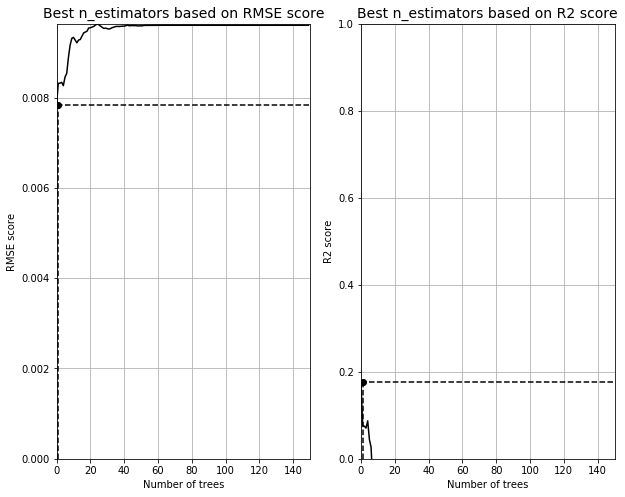

In [97]:
Best_n_estimator(GBR, df_features_scaled_PCA, df_target, df_features_test_scaled_PCA, df_target_test,150) 

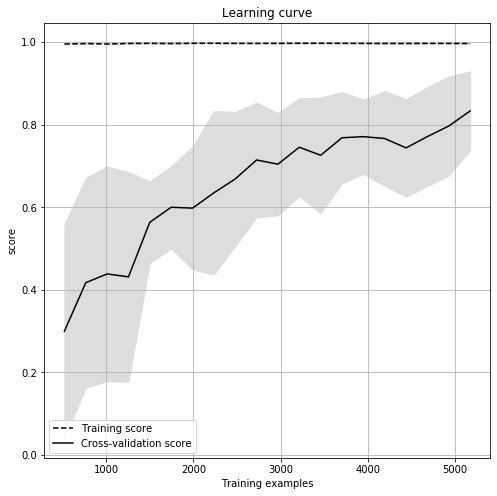

In [98]:
train_sizes=np.linspace(0.1, 1, 20)
plot_learning_curve(GBR,df_features_scaled_PCA, df_target, train_sizes)